In [2]:
import json
import numpy as np
import random
import pandas as pd

from evalplus.eval import (
    PASS,
    compatible_eval_result,
    estimate_pass_at_k,
    untrusted_check,
)


def find_matching_k(results1, results2):
    total_nr_tasks = len(results1["eval"])
    """Finds the smallest k for which pass@k of results2 matches pass@1 of results1."""
    pass_at_1_results1_base = estimate_pass_at_k(
        np.array([len(r) for r in results1["eval"].values()]),
        np.array([sum([r["base_status"] == PASS for r in res]) for res in results1["eval"].values()]),
        1
    ).mean()

    print(f"Base Pass@1 strong model: {pass_at_1_results1_base:.3f}")

    # compute strong model pass@1 for extra tests
    pass_at_1_results1_plus = estimate_pass_at_k(
        np.array([len(r) for r in results1["eval"].values()]),
        np.array([sum([r["plus_status"] == PASS for r in res]) for res in results1["eval"].values()]),
        1
    ).mean()

    print(f"Plus Pass@1 strong model: {pass_at_1_results1_plus:.3f}")
    
    k = 1
    while True:
        pass_at_k_results2 = estimate_pass_at_k(
            np.array([len(r) for r in results2["eval"].values()]),
            np.array([sum([r["base_status"] == PASS for r in res]) for res in results2["eval"].values()]),
            k
        ).mean()
        if pass_at_k_results2 >= pass_at_1_results1_base:
            return k, pass_at_1_results1_base, pass_at_1_results1_plus
        k += 1
        if k > total_nr_tasks:
            raise ValueError("No matching k found")

def evaluate_results(results, k):
    """Evaluates results based on the specified k."""
    base_success = 0
    plus_success = 0
    total_tasks = 0
    
    for task_results in results["eval"].values():
        total_tasks += 1
        # Select k random solutions
        selected_solutions = random.sample(task_results, min(k, len(task_results)))
        
        # Shuffle selected solutions
        random.shuffle(selected_solutions)
        
        # Find the first passing solution for base tests
        base_pass = False
        for solution in selected_solutions:
            if solution["base_status"] == PASS:
                base_success += 1
                base_pass = True
                break
        
        # Check for plus test success if base test passed
        if base_pass and solution["plus_status"] == PASS:
            plus_success += 1
    
    base_success_rate = base_success / total_tasks
    plus_success_rate = plus_success / total_tasks if base_success > 0 else 0

    return base_success_rate, plus_success_rate, base_success, plus_success, total_tasks

# Load json data
with open("chatgpt_temp_0.8/eval_results.json", "r") as f1, open("code-llama-7b_temp_0.8/eval_results.json", "r") as f2:
    results1 = json.load(f1)
    results2 = json.load(f2)

# Find matching k
k, pass_at_1_results1_base, pass_at_1_results1_plus = find_matching_k(results1, results2)
print(f"Smallest k with matching pass rate: {k}")

# Evaluate results2 based on matching k
base_success_rate, plus_success_rate, base_success, plus_success, total_tasks = evaluate_results(results2, k)
print(f"Base success rate: {base_success_rate:.3f}")
print(f"Plus success rate: {plus_success_rate:.3f}")
print(f"Base success: {base_success}")
print(f"Plus success: {plus_success}")
print(f"Total tasks: {total_tasks}")

Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 11
Base success rate: 0.701
Plus success rate: 0.549
Base success: 115
Plus success: 90
Total tasks: 164


In [3]:
# Define the strong model results file
results1_files = [
    "chatgpt_temp_0.8/eval_results.json",
    "gpt-4_temp_0.0/eval_results.json"
]

# Define a list of weak model results files
results2_files = [
    "code-llama-7b_temp_0.8/eval_results.json",
    "codegen-6b_temp_0.8/eval_results.json",
    "code-llama-13b_temp_0.8/eval_results.json",
    "vicuna-7b_temp_0.8/eval_results.json",
    "mistral-7b_temp_0.8/eval_results.json",
    "codegen2-7b_temp_0.8/eval_results.json",
    "codet5p-16b_temp_0.8/eval_results.json",
    "starcoder_temp_0.8/eval_results.json"


]

In [4]:
# Number of sampling repetitions
n_samples = 30

# Create an empty list to store the results
data = []

for results1_file in results1_files:
    # Iterate over weak model results files
    for results2_file in results2_files:
        # Load strong model results
        with open(results1_file, "r") as f1:
            results1 = json.load(f1)

        with open(results2_file, "r") as f2:
            results2 = json.load(f2)

        # Find matching k
        try:
            k, pass_at_1_results1_base, pass_at_1_results1_plus = find_matching_k(results1, results2)
            print(f"Smallest k with matching pass rate: {k}")
        except ValueError as e:
            print(f"Error processing {results2_file}: {e}")
            continue

        # Repeat sampling n times
        base_success_rates = []
        plus_success_rates = []
        for _ in range(n_samples):
            base_success_rate, plus_success_rate, _, _, _ = evaluate_results(results2, k)
            base_success_rates.append(base_success_rate)
            plus_success_rates.append(plus_success_rate)

        # Extract model names from file paths
        model_strong = results1_file.split("/")[0]
        model_weak = results2_file.split("/")[0]

        # Calculate mean and standard deviation for error bars
        mean_base_success_rate = np.mean(base_success_rates)
        std_base_success_rate = np.std(base_success_rates)
        mean_plus_success_rate = np.mean(plus_success_rates)
        std_plus_success_rate = np.std(plus_success_rates)
        sem_base_success_rate = np.std(base_success_rates) / np.sqrt(n_samples)  
        sem_plus_success_rate = np.std(plus_success_rates) / np.sqrt(n_samples) 

        # Append results to the data list
        data.append([model_strong, 
                    model_weak,
                    pass_at_1_results1_base,
                    pass_at_1_results1_plus,
                    k, 
                    mean_base_success_rate, 
                    sem_base_success_rate,
                    mean_plus_success_rate, 
                    sem_plus_success_rate])

# Create a Pandas DataFrame from the results
df = pd.DataFrame(data, columns=[
    "model_strong", 
    "model_weak", 
    "strong_pass@1_base",
    "strong_pass@1_plus",
    "k", 
    "weak_base_success_rate",
    "weak_base_success_rate_sem",
    "weak_plus_success_rate",
    "weak_plus_success_rate_sem",
])

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv("evaluation_metrics.csv", index=False)

Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 11
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 73
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 6
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Error processing vicuna-7b_temp_0.8/eval_results.json: No matching k found
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 29
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Error processing codegen2-7b_temp_0.8/eval_results.json: No matching k found
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 25
Base Pass@1 strong model: 0.694
Plus Pass@1 strong model: 0.628
Smallest k with matching pass rate: 27
Base Pass@1 strong model: 0.884
Plus Pass@1 strong model: 0.793
Smallest k with matching pass rate: 80


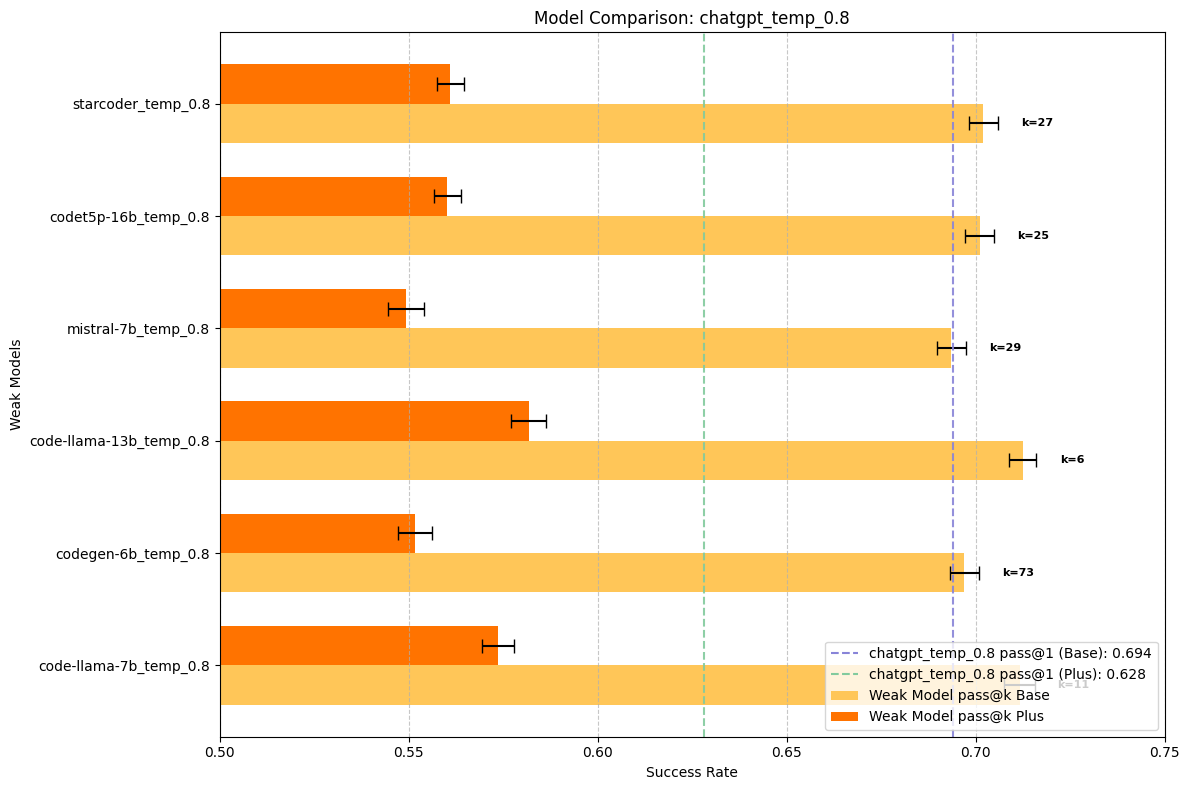

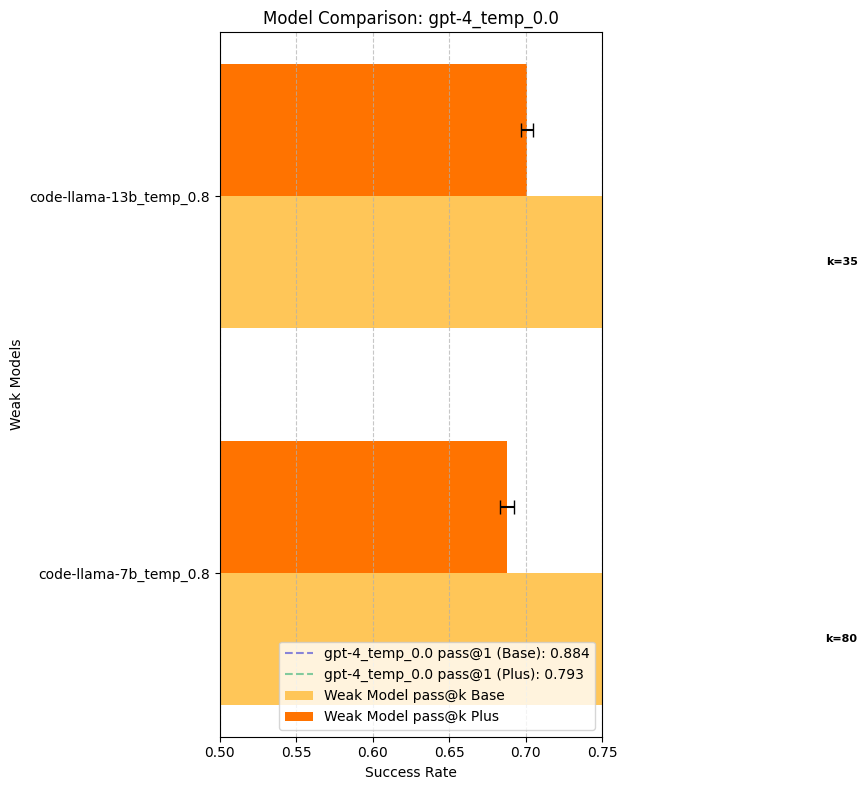

In [5]:
import matplotlib.pyplot as plt

# Get unique strong models
strong_models = df['model_strong'].unique()

# Create a plot for each strong model
for strong_model in strong_models:
    # Filter data for the current strong model
    model_df = df[df['model_strong'] == strong_model]
    
    # Prepare the data
    model_combinations = model_df['model_weak']
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set the width of each bar and the positions of the bars
    bar_width = 0.35
    r1 = range(len(model_combinations))
    r2 = [x + bar_width for x in r1]
    
    # Create the bars with error bars
    base_bars = ax.barh(r1, model_df['weak_base_success_rate'], xerr=model_df['weak_base_success_rate_sem'], 
            height=bar_width, label='Weak Model pass@k Base', color='#ffc658', capsize=5)
    plus_bars = ax.barh(r2, model_df['weak_plus_success_rate'], xerr=model_df['weak_plus_success_rate_sem'], 
            height=bar_width, label='Weak Model pass@k Plus', color='#ff7300', capsize=5)
    
    # Add k value labels to each bar
    for i, (base_bar, plus_bar) in enumerate(zip(base_bars, plus_bars)):
        k_value = model_df['k'].iloc[i]
        ax.text(base_bar.get_width() + 0.01, base_bar.get_y() + base_bar.get_height()/2, f'k={k_value}', 
                va='center', ha='left', fontsize=8, color='black', fontweight='bold')
        # ax.text(plus_bar.get_width() + 0.01, plus_bar.get_y() + plus_bar.get_height()/2, f'k={k_value}', 
        #         va='center', ha='left', fontsize=8, color='black', fontweight='bold')
    
    # Customize the plot
    ax.set_ylabel('Weak Models')
    ax.set_xlabel('Success Rate')
    ax.set_xlim(0.5, 0.75)
    ax.set_title(f'Model Comparison: {strong_model}')
    ax.set_yticks([r + bar_width/2 for r in range(len(model_combinations))])
    ax.set_yticklabels(model_combinations)
    
    # Add vertical lines for strong model performance
    strong_base = model_df['strong_pass@1_base'].iloc[0]
    strong_plus = model_df['strong_pass@1_plus'].iloc[0]
    ax.axvline(strong_base, color='#8884d8', linestyle='--', alpha=0.9)
    ax.axvline(strong_plus, color='#82ca9d', linestyle='--', alpha=0.9)
    
    # Add label for strong model performance to legend
    ax.plot([], [], color='#8884d8', linestyle='--', label=f'{strong_model} pass@1 (Base): {strong_base:.3f}')
    ax.plot([], [], color='#82ca9d', linestyle='--', label=f'{strong_model} pass@1 (Plus): {strong_plus:.3f}')
    
    # Add a legend
    ax.legend(loc='lower right')
    
    # Add grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()